# XSVS pipeline

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from timeit import timeit

from databroker import DataBroker as db, get_images, get_table, get_events
from filestore.api import register_handler, deregister_handler
from filestore.retrieve import _h_registry, _HANDLER_CACHE
# register the fancy lazy chx eiger handler
# from chxtools import handlers

## Lazy Eiger Handler (later will goto databroker)


In [2]:
import h5py
from filestore.retrieve import HandlerBase
from eiger_io.pims_reader import EigerImages

EIGER_MD_DICT = {
    'y_pixel_size': 'entry/instrument/detector/y_pixel_size',
    'x_pixel_size': 'entry/instrument/detector/x_pixel_size',
    'detector_distance': 'entry/instrument/detector/detector_distance',
    'incident_wavelength': 'entry/instrument/beam/incident_wavelength',
    'frame_time': 'entry/instrument/detector/frame_time',
    'beam_center_x': 'entry/instrument/detector/beam_center_x',
    'beam_center_y': 'entry/instrument/detector/beam_center_y',
    'count_time': 'entry/instrument/detector/count_time',
    'pixel_mask': 'entry/instrument/detector/detectorSpecific/pixel_mask',
}

class FixedEigerImages(EigerImages):
    def __init__(self, path, metadata):
        super().__init__(path)
        self._metadata = metadata
    
    @property
    def md(self):
        return self._metadata
    
    @property
    def dtype(self):
        return self.pixel_type
    
    @property
    def shape(self):
        return self.frame_shape

class LazyEigerHandler(HandlerBase):
    specs = {'AD_EIGER'} | HandlerBase.specs
    def __init__(self, fpath, frame_per_point, mapping=None):
        # create pims handler
        self.vals_dict = EIGER_MD_DICT.copy()
        if mapping is not None:
            self.vals_dict.update(mapping)
        self._base_path = fpath
        self.fpp = frame_per_point

    def __call__(self, seq_id):
        import h5py
        master_path = '{}_{}_master.h5'.format(self._base_path, seq_id)
        md = {}
        print('hdf5 path = %s' % master_path)
        with h5py.File(master_path, 'r') as f:
            md = {k: f[v].value for k, v in self.vals_dict.items()}
        # the pixel mask from the eiger contains:
        # 1  -- gap
        # 2  -- dead
        # 4  -- under-responsive
        # 8  -- over-responsive
        # 16 -- noisy
        pixel_mask = md['pixel_mask']
        pixel_mask[pixel_mask>0] = 1
        pixel_mask[pixel_mask==0] = 2
        pixel_mask[pixel_mask==1] = 0
        pixel_mask[pixel_mask==2] = 1
        md['framerate'] = 1./md['frame_time']
        # TODO Return a multi-dimensional PIMS seq
        return FixedEigerImages(master_path, md)

deregister_handler('AD_EIGER')
_HANDLER_CACHE.clear()
register_handler('AD_EIGER', LazyEigerHandler)

## Get the events from 

In [3]:
def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print("    %s: %s" % (key, val))

f = h5py.File('/XF11ID/data/2015/10/16/bcdd8b95-6adc-476b-9c65_25_master.h5','r')
#f.visititems(print_attrs)

In [4]:
events = get_events(db['e59f567d'], ['eiger_4M_cam_img_image_lightfield'])
ev = next(events)

imgs = ev['data']['eiger_4M_cam_img_image_lightfield']
imgs

hdf5 path = /XF11ID/data/2015/10/16/bcdd8b95-6adc-476b-9c65_25_master.h5


<Frames>
Length: 3000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint16

## Interactive way to browse through images.
Note : Provide the number of images that you want to browse

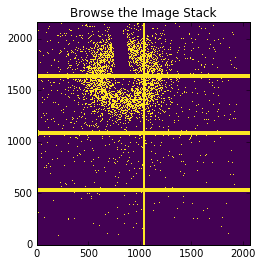

<function __main__.view_image>

In [5]:
from ipywidgets import interact
%matplotlib inline
def view_image(i):
    plt.imshow(imgs[i], interpolation='nearest', cmap='viridis',
               vmin=0, vmax=1e0, origin="lower")
    plt.title("Browse the Image Stack")
    plt.show()
    
interact(view_image, i=(0, 2999))

### hey, let's see if any images are bad!

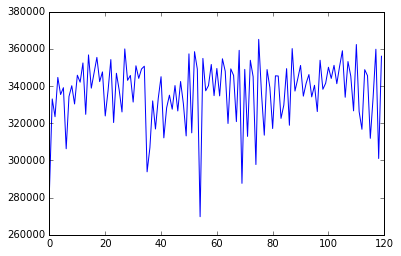

In [6]:
imgsum = [np.sum(img*imgs.md['pixel_mask']) for img in imgs[::25]]

%matplotlib inline
plt.plot(imgsum)

## Get the Averaged Image Data

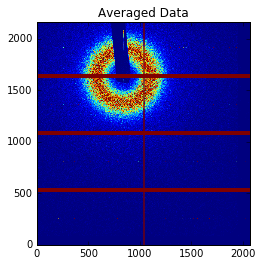

In [7]:
avg_img = np.average(imgs[::50], axis=0)

# Plot the result
fig, ax = plt.subplots()
ax.imshow(avg_img, vmin=0, vmax=1e0, origin="lower")
ax.set_title("Averaged Data")
plt.show()

## Note:  Obtain the following experiment information 

* The physical size of the pixels
* Wavelegth of the X-rays  - (units in Angstroms)
* Detector to sample distance
* Exposure time - (units in seconds)
* acqusition period - (units in seconds)
* dead time - (units in seconds)
* time per frame = (exposure time + dead_time or acqusition period) - (units in seconds)

In [8]:
# The physical size of the pixels
dpix = 0.075  
 
lambda_ = 1.5498    # wavelegth of the X-rays in Angstroms
Ldet = 5000.        # detector to sample distance

exposuretime= 100 * 10**(-3) 
acquisition_period = 100 * 10**(-3)  

#deadtime= 0   # 60e-6 
#timeperframe = exposuretime + deadtime
timeperframe = acquisition_period  

## Import all the required packages for  Data Analysis

* scikit-xray - data analysis tools for X-ray science 
    - https://github.com/scikit-xray/scikit-xray
* xray-vision - plotting helper functions for X-ray science
    - https://github.com/Nikea/xray-vision

In [9]:
import xray_vision
import xray_vision.mpl_plotting as mpl_plot  
from xray_vision.mask.manual_mask import ManualMask

import skxray.core.roi as roi
import skxray.core.speckle as speckle
import skxray.core.utils as utils

## Input the mask file

In [10]:
cd Analysis_Pipelines/

/home/sameera/Analysis_Pipelines


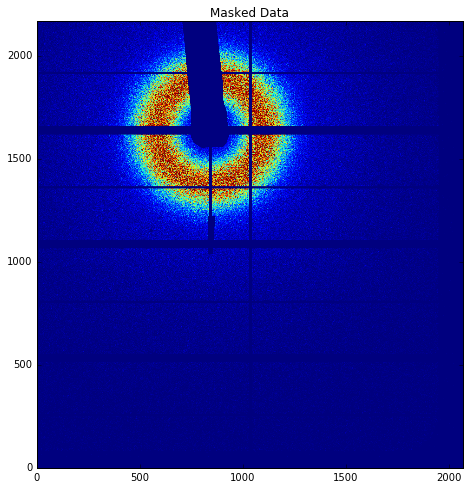

In [11]:
%matplotlib inline

mask = ~np.load("./mask2.npy")

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(avg_img*mask, vmin=0, vmax=1e0, origin="lower")
ax.set_title("Masked Data")
plt.show()

# Get the approximate center and see the statistic to make sure

In [12]:
center = (1634.66, 838.6)  # center of the speckle pattern

### Circular Average : compute the radial integartion from the center of the speckle pattern

In [13]:

bin_centers, ring_averages= roi.circular_average(avg_img*mask, center, threshold=0, nx=100,
                                         pixel_size=(dpix, dpix))

#  convert to q (reciprocal space)
two_theta = utils.radius_to_twotheta(Ldet, bin_centers)
q_val = utils.twotheta_to_q(two_theta, lambda_)

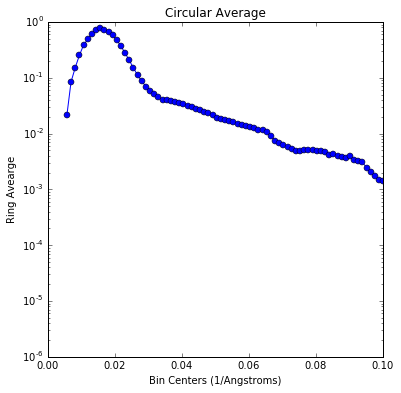

In [14]:
fig, axes = plt.subplots( figsize=(6, 6))
axes.semilogy(q_val, ring_averages, '-o')
axes.set_title("Circular Average")
axes.set_ylabel("Ring Avearge")
axes.set_xlabel("Bin Centers (1/Angstroms)")
axes.set_xlim(0, 0.1)
plt.show()

## Create label array (Q rings)

In [15]:
inner_radius = 100# radius of the first ring
width = 10        # width of each ring
spacing = 3      # no spacing between rings
num_rings = 15   # number of rings

#  find the edges of the required rings
edges = roi.ring_edges(inner_radius, width, spacing, num_rings)
edges

array([[ 100.,  110.],
       [ 113.,  123.],
       [ 126.,  136.],
       [ 139.,  149.],
       [ 152.,  162.],
       [ 165.,  175.],
       [ 178.,  188.],
       [ 191.,  201.],
       [ 204.,  214.],
       [ 217.,  227.],
       [ 230.,  240.],
       [ 243.,  253.],
       [ 256.,  266.],
       [ 269.,  279.],
       [ 282.,  292.]])

### Covert the q rings edge values to reciprocal space in Angstroms

In [16]:
two_theta = utils.radius_to_twotheta(Ldet, edges*dpix)
q_ring_val = utils.twotheta_to_q(two_theta, lambda_)

q_ring_val

array([[ 0.00608128,  0.00668941],
       [ 0.00687185,  0.00747997],
       [ 0.00766241,  0.00827054],
       [ 0.00845297,  0.0090611 ],
       [ 0.00924354,  0.00985166],
       [ 0.0100341 ,  0.01064222],
       [ 0.01082466,  0.01143278],
       [ 0.01161522,  0.01222334],
       [ 0.01240578,  0.0130139 ],
       [ 0.01319634,  0.01380446],
       [ 0.0139869 ,  0.01459502],
       [ 0.01477745,  0.01538557],
       [ 0.01556801,  0.01617613],
       [ 0.01635856,  0.01696668],
       [ 0.01714911,  0.01775723]])

####  get the center of the q ring

In [17]:
q_ring_center = np.array( [(q_ring_val[i][0] + q_ring_val[i][1])/2 for 
                           i in range(num_rings)])
q_ring_center

array([ 0.00638534,  0.00717591,  0.00796647,  0.00875704,  0.0095476 ,
        0.01033816,  0.01112872,  0.01191928,  0.01270984,  0.0135004 ,
        0.01429096,  0.01508151,  0.01587207,  0.01666262,  0.01745317])

####  Plot the q ring center values 

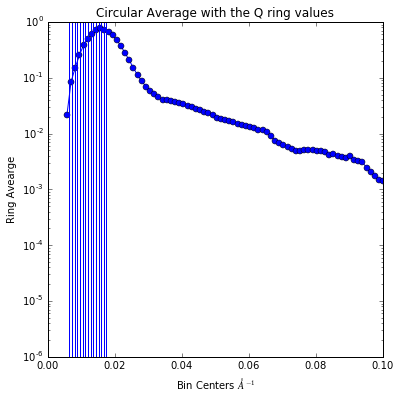

In [18]:
fig, axes = plt.subplots( figsize=(6, 6))
axes.semilogy(q_val, ring_averages, '-o')
axes.set_title("Circular Average with the Q ring values")
axes.set_ylabel("Ring Avearge")
axes.set_xlabel("Bin Centers "+ r'$\AA^{-1}$')
axes.set_xlim(0, 0.1)
for i in range(num_rings):
    axes.axvline(q_ring_center[i])
plt.show()

#### Plot the labled array

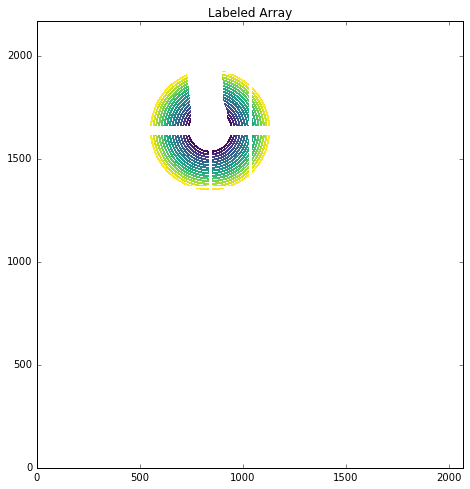

In [19]:
rings = roi.rings(edges, center, avg_img.shape)

ring_mask = rings*mask
#% matplotlib notebook
# plot the figure
fig, axes = plt.subplots(figsize=(8,8))
axes.set_title("Labeled Array")
im = mpl_plot.show_label_array(axes, ring_mask, cmap='viridis', origin="lower")
plt.show()

##  Mask the images

In [20]:
class Masker:
    def __init__(self, indexable, mask):
        self.indexable = indexable
        self.mask = mask
    def __getitem__(self, key):
        return self.indexable[key] * mask
    
    
masker = Masker(imgs, mask)

##  Mean intensities for each ring

In [21]:
n = 50
mean_int_sets, index_list = roi.mean_intensity(masker[::50], ring_mask)

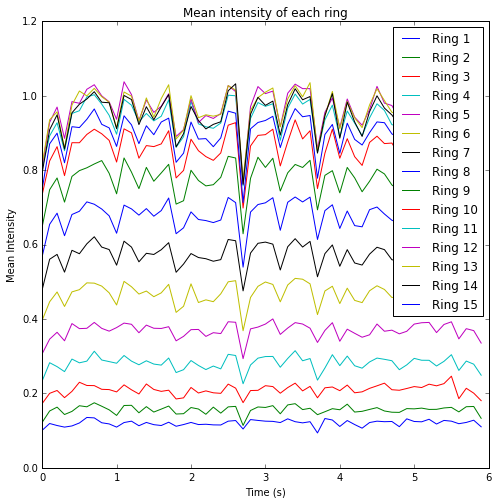

In [22]:
time = np.arange(len(imgs[::n]))*timeperframe  # get the time for each frame

%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Mean intensity of each ring")
for i in range(num_rings):
    ax.plot(time, mean_int_sets[:,i], label="Ring "+str(i+1))
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Mean Intensity")
ax.legend() 
plt.show()

### mean intensity for each ring

In [23]:
mean_int_ring = np.mean(mean_int_sets, axis=0)
mean_int_ring

array([ 0.12014245,  0.15596263,  0.20953256,  0.28111706,  0.36892017,
        0.46895465,  0.57331678,  0.67854588,  0.77840172,  0.86168399,
        0.93878177,  0.9664946 ,  0.96551473,  0.94981534,  0.89814016])

### Find the brightest pixel in any ROI in any image in the image set.
Using roi_max_counts function from skxray.core.roi module

In [24]:
max_cts = roi.roi_max_counts(masker[::100], ring_mask)
max_cts

17

## XSVS analysis

#### Find the integration times¶
using skxray.core.utils.geometric_series

In [26]:
time_steps = utils.geometric_series(2, 30)
time_steps

[1, 2, 4, 8, 16]

In [27]:
spe_cts_all, std_dev = speckle.xsvs((masker,), ring_mask, timebin_num=2,
                             number_of_img=30, max_cts=17)

### get the bin edges

In [28]:
num_times = spe_cts_all.shape[0]
num_rois = num_rings
norm_bin_edges, norm_bin_centers = speckle.normalize_bin_edges(num_times,
                                                            num_rois, mean_int_ring, max_cts)

### Plot the results for each q ring

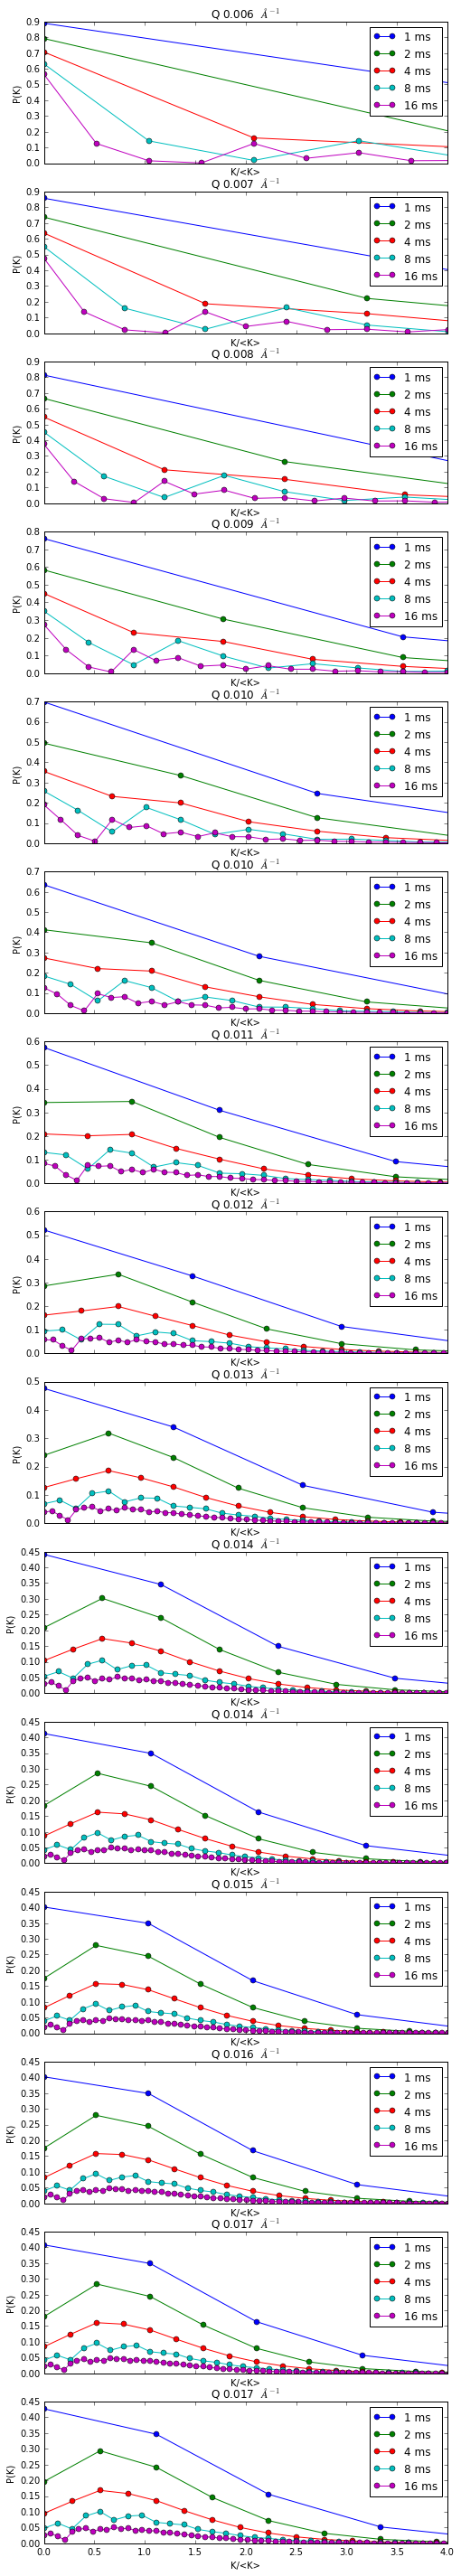

In [57]:
fig, axes = plt.subplots(num_rings, sharex=True, figsize=(8, 50))
#axes[num_rings-1].set_xlabel(r"$\tau,sec$", fontsize=22)
for i in range(num_rings):
    for j in range(num_times):
        axes[i].set_xlabel("K/<K>")
        axes[i].set_ylabel("P(K)")
        art, = axes[i].plot(norm_bin_edges[j, i][:-1], spe_cts_all[j, i], '-o',
                     label=str(time_steps[j])+" ms")
        axes[i].set_xlim(0, 4)
        axes[i].set_title("Q "+ '%.3f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
        axes[i].legend()
plt.show()

## Fit XSVS results